In [1]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Calculate_Disease_Enrichment")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from mjm_tools import zip_res_range, unzip_res_range

from collections import defaultdict

# Paramaters for file locations

In [2]:
# Base directory for whole project
base_dir = "/home/sdw95/3D_SARS2"

# Parse Disease Mut Data from SARS2 Interactors

In [3]:
# Read in Protein into to get list of human interactors
proteins = pd.read_csv("{0}/Data/Proteins.txt".format(base_dir), sep="\t")
uni2seq = proteins.set_index("ID")["Sequence"].to_dict()

# Parse HGDM

In [4]:
# Read in / subset HGMD dataset for only SARS2 interactors
hgmd = pd.read_csv("{0}/HGMD_201801_uniprotmapped.txt".format(base_dir), sep="\t")
hgmd_sub = hgmd[hgmd["UNIPROT_ACC"].map(lambda x: x in uni2seq.keys())]

In [5]:
print len(hgmd_sub)
hgmd_sub.head()

3251


ID CLASS           DB CHROM     POS_HG19   POS_HG38 REF ALT  GENE  \
79    CM168654   DM?  rs746800707    20   34828310.0   36240388   G   A  AAR2   
110   CM132658    DM          NaN     7  121726095.0  122086041   A   G  AASS   
111   CM132655    DM  rs587777125     7  121773587.0  122133533   G   A  AASS   
112   CM132656    DM  rs587777126     7  121753194.0  122113140   T   G  AASS   
113  CM1514080   DM?          NaN     7  121773654.0  122133600   G   A  AASS   

     ENTREZ_GENE_ID                    DNA CODON_CHANGE                 PROT  \
79          25980.0   NM_015511.4:c.520G-A      GTG-ATG  NP_056326.2:p.V174M   
110         10157.0  NM_005763.3:c.2155A-G      ACT-GCT  NP_005754.2:p.T719A   
111         10157.0   NM_005763.3:c.194G-A      CGG-CAG   NP_005754.2:p.R65Q   
112         10157.0  NM_005763.3:c.1256T-G      CTT-CGT  NP_005754.2:p.L419R   
113         10157.0   NM_005763.3:c.127G-A      GCT-ACT   NP_005754.2:p.A43T   

    UNIPROT_ACC  AA_POS AA_CHANGE  \
79       Q9Y312     174        VM   
110      Q9UDR5     719        TA   
111      Q9UDR5      65        RQ   
112      Q9UDR5     419        LR   
113      Q9UDR5      43        AT   

                                                  PHEN      PMID  
79   Developmental delay, microcephaly, brain & hea...  27435318  
110                                    Hyperlysinaemia  23570448  
111                                    Hyperlysinaemia  23570448  
112                                    Hyperlysinaemia  23570448  
113                                      Schizophrenia  26666178

In [6]:
# Approximate fraction of all human proteins with disease annotations
print len(hgmd["UNIPROT_ACC"].unique()) / 20000.0

# Fraction of SARS2 interactors with disease annotations
len(hgmd_sub["UNIPROT_ACC"].value_counts()) / float(len([x for x in uni2seq if not "COVID" in x]))

0.33805


0.4246987951807229

In [7]:
# Simple Odds Ratio for enrichment of general disease status
# in SARS2 interactor sub-set vs. whole proteome
n_proteome = 20350
n_interactors = len([x for x in uni2seq if not "COVID" in x])

a = len(hgmd_sub["UNIPROT_ACC"].unique())
b = n_interactors - len(hgmd_sub["UNIPROT_ACC"].unique())
c = len(hgmd["UNIPROT_ACC"].unique()) - len(hgmd_sub["UNIPROT_ACC"].unique())
d = n_proteome - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

               Case  Non-Case
Exposed       141.0     191.0
Non-Exposed  6620.0   13398.0


(0.57923705921209434,
 0.84511612335858377,
 0.31335799506560508,
 0.00016955299569887394)

In [8]:
# Map phenotype to number of genes associated with it for each
# the whole proteome and the subset containing SARS2 interactors
phen2genes_hgmd = defaultdict(int)
phen2genes_hgmd_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(hgmd.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        for real_phen in phen.split(";"):
            phen2genes_hgmd[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_hgmd_sub[real_phen] += 1

In [9]:
# Calculate Odds ratio per disease term
phen2OR_hgmd = dict()
for phen in tqdm_notebook(phen2genes_hgmd.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_hgmd_sub[phen]
    b = n_interactors - phen2genes_hgmd_sub[phen]
    c = phen2genes_hgmd[phen] - phen2genes_hgmd_sub[phen]
    d = n_proteome - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_hgmd[phen] = [OR, up, low, p, a, b, c, d]

In [10]:
# Concatenate summary for odds ratio from all disease terms
# Counts Column Interpretations...
# A - Has gene phenotype and is a SARS2 interactor
# B - No gene phenotype but is a SARS2 interactor
# C - Has gene phenotype but is not a SARS2 interactor
# D - No gene phenotype and not a SARS2 interactor
OR_summary_hgmd = pd.DataFrame([[k] + v for k, v in phen2OR_hgmd.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [11]:
# Check to see if there are any terms with perfect enrichment
# (all disease assocated genes are in interactome)
# Particularly is the A count is high
# NOTE: The odds ratio for this case can't be calculated, but
#       may be interesting, so we look at it separately
OR_summary_hgmd[OR_summary_hgmd["C"] == 0].sort_values("A", ascending=False)

Phen  OR  Lower  Upper  \
13                         Reduced 17,20 lyase activity NaN    NaN    NaN   
4991                     Diabetes, type 2, reduced risk NaN    NaN    NaN   
5955                                       Sialidosis 1 NaN    NaN    NaN   
5962              Fetal akinesia with cerebral ischemia NaN    NaN    NaN   
6040                   Altered subcellular localization NaN    NaN    NaN   
6058                     Alkyl-DHAP synthase deficiency NaN    NaN    NaN   
6068             Progressive cerebello-cerebral atrophy NaN    NaN    NaN   
6187              Osteochondrodysplasia, complex lethal NaN    NaN    NaN   
6203  Marfan syndrome with thoracic aortic aneurysm ... NaN    NaN    NaN   
6281                                    Fibrillinopathy NaN    NaN    NaN   
6328                      Cerebellar ataxia and atrophy NaN    NaN    NaN   
6419            Stiff skin syndrome with ectopia lentis NaN    NaN    NaN   
6494  Developmental delay, microcephaly and neurobeh... NaN    NaN    NaN   
6518     Increased head circumference, association with NaN    NaN    NaN   
6611                                     Bruck syndrome NaN    NaN    NaN   
6629  Global developmental delay, hypotonia and weak... NaN    NaN    NaN   
6731             Thoracic aortic aneurysm or dissection NaN    NaN    NaN   
6803  Optic atrophy, autosomal dominant, with hearin... NaN    NaN    NaN   
6844              Hypomyelination & developmental delay NaN    NaN    NaN   
6883         Cardiomyopathy, dilated/Myocarditis, acute NaN    NaN    NaN   
6893                      NADH-cyb5R deficiency, type 1 NaN    NaN    NaN   
5832  Arthrogryposis, severe with developmental dela... NaN    NaN    NaN   
5824                      Increased PLAT antigen levels NaN    NaN    NaN   
5799                           Glucosidase 1 deficiency NaN    NaN    NaN   
5370  Neurodevelopmental delay, hypotonia, strabismu... NaN    NaN    NaN   
5069            Congenital disorder of glycosylation 1h NaN    NaN    NaN   
5083    Arthrogryposis multiplex congenita, neuropathic NaN    NaN    NaN   
5111              Striatonigral degeneration, infantile NaN    NaN    NaN   
5203  IL-17RA deficiency with bacterial and fungal i... NaN    NaN    NaN   
5238  Moderate intellectual disability, ataxia and t... NaN    NaN    NaN   
...                                                 ...  ..    ...    ...   
4398     Hypotonia with infantile spasms and strabismus NaN    NaN    NaN   
4499                         Focal dystonia, late onset NaN    NaN    NaN   
4500          Wolfram-like syndrome, autosomal dominant NaN    NaN    NaN   
4584   Decreased estradiol 17beta-glucuronide transport NaN    NaN    NaN   
4603                                      Fabry disease NaN    NaN    NaN   
4626  Thoracic aortic aneurysm with aortic regurgita... NaN    NaN    NaN   
4668                           Marfan syndrome features NaN    NaN    NaN   
3737     Ectopia lentis & varicose great saphenous vein NaN    NaN    NaN   
3719                       Reduced multidrug resistance NaN    NaN    NaN   
2904              Transfusion-related acute lung injury NaN    NaN    NaN   
3364     Microlissencephaly with multinucleated neurons NaN    NaN    NaN   
2942                 Geleophysic / acromicric dysplasia NaN    NaN    NaN   
2996               Phenotype modification in cutis laxa NaN    NaN    NaN   
3048                       Left ventricular hypertrophy NaN    NaN    NaN   
3098                             Fabry disease, cardiac NaN    NaN    NaN   
3165                                     POR deficiency NaN    NaN    NaN   
3244                                   GRACILE syndrome NaN    NaN    NaN   
3265                              Methaemoglobinaemia 3 NaN    NaN    NaN   
3323                         Temporomandibular disorder NaN    NaN    NaN   
3375      Dystonia, cerebellar atrophy & cardiomyopathy NaN    NaN    NaN   
3700  Intellectual disability, early-onset spas

In [12]:
# Look at significantly enriched terms
OR_summary_hgmd[(OR_summary_hgmd["p-value"] <= 0.05) & (OR_summary_hgmd["OR"] > 0)].sort_values("A", ascending=False)

Phen        OR     Lower  \
483                                Complex I deficiency  2.570948  4.060466   
8172                           Sudden unexplained death  1.700632  3.383679   
8675               Congenital disorder of glycosylation  3.423340  5.201033   
4709       Intellectual disability, autosomal recessive  2.465255  4.177608   
1804                           Congenital heart disease  2.151519  3.850012   
3649   Marfan/Thoracic aortic aneurysms and dissections  5.337509  7.923537   
2651                    Adolescent idiopathic scoliosis  5.922544  8.754526   
6621                                   Cuticular drusen  4.337293  6.651371   
1340                                         Cutis laxa  5.337509  7.923537   
7221                    Marfan syndrome with aortopathy  4.114829  6.387402   
417                                Sudden cardiac death  3.014716  5.149056   
6749          Thoracic aortic aneurysms and dissections  3.336860  5.502193   
5138                            Frontotemporal dementia  3.336860  5.502193   
2841                    Schizophrenia, association with  2.220373  4.301213   
6938                    Muscular dystrophy, limb-girdle  2.113314  4.188869   
1677                           Thoracic aortic aneurysm  4.600400  6.971364   
6640             Immunodeficiency, primary, modifier of  3.332928  6.391135   
6260     Neuronal ceroid lipofuscinosis, late infantile  3.332928  6.391135   
6233  Developmental delay, epilepsy, ataxia & mitoch...  5.918251  9.920193   
6139                  Cardiomyopathy, right ventricular  4.918179  8.384848   
6121                         Bardet-Biedl like features  5.918251  9.920193   
6115                          Aortic aneurysm, thoracic  4.333144  7.601968   
6091            Amyotrophic lateral sclerosis, juvenile  4.918179  8.384848   
72                                     Furlong syndrome  5.918251  9.920193   
6018                                      Optic atrophy  3.332928  6.391135   
5932             Hepatitis B, chronic, association with  4.918179  8.384848   
5889           Neuronal ceroid lipofuscinosis, juvenile  4.333144  7.601968   
5788                             Mandibular prognathism  4.918179  8.384848   
5736                      Arrhythmogenic cardiomyopathy  3.596034  6.697509   
5631              Abnormality of metabolism/homeostasis  3.596034  6.697509   
...                                                 ...       ...       ...   
3658                                     Ectopia lentis  5.918251  9.920193   
4885                                 Cerebellar atrophy  5.918251  9.920193   
4848                     Osteoporosis, association with  3.596034  6.697509   
84    Arrhythmogenic right ventricular dysplasia/car...  3.110463  6.137386   
4773                   Ischaemic stroke, increased risk  4.918179  8.384848   
4361  Arrhythmogenic right ventricular cardiomyopath...  5.918251  9.920193   
4357                       Mitochondrial encephalopathy  4.333144  7.601968   
4333                        Marfan syndrome, incomplete  5.918251  9.920193   
4122                              Geleophysic dysplasia  5.918251  9.920193   
3998    Prostate cancer, reduced risk, association with  4.333144  7.601968   
3945              Abnormality of the respiratory system  5.918251  9.920193   
3913           Abnormality of the cardiovascular system  4.333144  7.601968   
3834       Osteogenesis imperfecta, autosomal recessive  3.596034  6.697509   
3754                      Ectopia lentis, isolated form  5.918251  9.920193   
3654                                Ataxia, early-onset  4.918179  8.384848   
2271                   Abnormality of the mitochondrion  3.110463  6.137386   
3575       Thoracic aortic aneurysm, phenotype modifier  5.918251  9.920193   
3553                          Dementia with Lewy bodies  3.332928  6.391135   
3409                        Cleft palate, non-syndromic  3.110463  6.137386   
3379  Hearing loss, no

# Parse ClinVar

In [13]:
# Read in / subset ClinVar dataset for only SARS2 interactors
clinvar = pd.read_csv("{0}/ClinVar2017_missense_uniprotmapped.txt".format(base_dir), sep="\t")
clinvar_sub = clinvar[clinvar["UNIPROT_ACC"].map(lambda x: x in uni2seq.keys())]

In [14]:
# Approximate fraction of all human proteins with disease annotations
print len(clinvar["UNIPROT_ACC"].unique()) / 20000.0

# Fraction of SARS2 interactors with disease annotations
len(clinvar_sub["UNIPROT_ACC"].value_counts()) / float(len([x for x in uni2seq if not "COVID" in x]))

0.23735


0.3192771084337349

In [15]:
# Simple Odds Ratio for enrichment of general disease status
# in SARS2 interactor sub-set vs. whole proteome
n_proteome = 20350
n_interactors = len([x for x in uni2seq if not "COVID" in x])

a = len(clinvar_sub["UNIPROT_ACC"].unique())
b = n_interactors - len(clinvar_sub["UNIPROT_ACC"].unique())
c = len(clinvar["UNIPROT_ACC"].unique()) - len(clinvar_sub["UNIPROT_ACC"].unique())
d = n_proteome - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

               Case  Non-Case
Exposed       106.0     226.0
Non-Exposed  4641.0   15377.0


(0.63600795542177435,
 0.91818058839574224,
 0.35383532244780647,
 0.00010467973792360752)

In [16]:
# Map phenotype to number of genes associated with it for each
# the whole proteome and the subset containing SARS2 interactors
phen2genes_clinvar = defaultdict(int)
phen2genes_clinvar_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(clinvar.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        phen = str(phen)
        for real_phen in phen.split(";"):
            phen2genes_clinvar[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_clinvar_sub[real_phen] += 1

In [17]:
# Calculate Odds ratio per disease term
phen2OR_clinvar = dict()
for phen in tqdm_notebook(phen2genes_clinvar.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_clinvar_sub[phen]
    b = n_interactors - phen2genes_clinvar_sub[phen]
    c = phen2genes_clinvar[phen] - phen2genes_clinvar_sub[phen]
    d = n_proteome - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_clinvar[phen] = [OR, up, low, p, a, b, c, d]

In [18]:
# Concatenate summary for odds ratio from all disease terms
# Counts Column Interpretations...
# A - Has gene phenotype and is a SARS2 interactor
# B - No gene phenotype but is a SARS2 interactor
# C - Has gene phenotype but is not a SARS2 interactor
# D - No gene phenotype and not a SARS2 interactor
OR_summary_clinvar = pd.DataFrame([[k] + v for k, v in phen2OR_clinvar.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [19]:
# Check to see if there are any terms with perfect enrichment
# (all disease assocated genes are in interactome)
# Particularly is the A count is high
# NOTE: The odds ratio for this case can't be calculated, but
#       may be interesting, so we look at it separately
OR_summary_clinvar[OR_summary_clinvar["C"] == 0].sort_values("A", ascending=False)

Phen  OR  Lower  Upper  \
2626  Arrhythmogenic right ventricular cardiomyopath... NaN    NaN    NaN   
2957                    WFS1-Related Spectrum Disorders NaN    NaN    NaN   
1774             Congenital contractural arachnodactyly NaN    NaN    NaN   
5760                             WFS1-Related Disorders NaN    NaN    NaN   
4971                               Acromicric dysplasia NaN    NaN    NaN   
3797                                Stiff skin syndrome NaN    NaN    NaN   
1360  Microcephalic Osteodysplastic Primordial Dwarfism NaN    NaN    NaN   
4373                                         Dystonia 1 NaN    NaN    NaN   
1491  Diabetes mellitus AND insipidus with optic atr... NaN    NaN    NaN   
1540         Primary autosomal recessive microcephaly 3 NaN    NaN    NaN   
523           Mental retardation, autosomal dominant 42 NaN    NaN    NaN   
1998                 Multifocal epileptiform discharges NaN    NaN    NaN   
502   Medium-chain acyl-coenzyme A dehydrogenase def... NaN    NaN    NaN   
1004                                    Limb hypertonia NaN    NaN    NaN   
1282                   Ceroid lipofuscinosis neuronal 1 NaN    NaN    NaN   
2442                 Age-related macular degeneration 3 NaN    NaN    NaN   
3537                         Marinesco-Sj�gren syndrome NaN    NaN    NaN   
4091  Microcephalic osteodysplastic primordial dwarf... NaN    NaN    NaN   
4634                     Fabry disease, cardiac variant NaN    NaN    NaN   
2753                            Geleophysic dysplasia 2 NaN    NaN    NaN   
7                                         MASS syndrome NaN    NaN    NaN   
108                                   Sialidosis type I NaN    NaN    NaN   
3070                                Sialidosis, type II NaN    NaN    NaN   
3140  Focal seizures with impairment of consciousnes... NaN    NaN    NaN   
563                                    GRACILE syndrome NaN    NaN    NaN   
3247  Acyl-CoA dehydrogenase family, member 9, defic... NaN    NaN    NaN   
3874       EEG with generalized epileptiform discharges NaN    NaN    NaN   
2915                     Cutis Laxa, Dominant/Recessive NaN    NaN    NaN   
3597          Wolfram-like syndrome, autosomal dominant NaN    NaN    NaN   
6008  Antley-Bixler syndrome with genital anomalies ... NaN    NaN    NaN   
...                                                 ...  ..    ...    ...   
128                                   Aortic dilatation NaN    NaN    NaN   
85                                         Ulnar bowing NaN    NaN    NaN   
1690               Vitamin K-Dependent Clotting Factors NaN    NaN    NaN   
1845                            Fetal akinesia sequence NaN    NaN    NaN   
3481                               Parkinson disease 11 NaN    NaN    NaN   
1891  Alopecia, neurologic defects, and endocrinopat... NaN    NaN    NaN   
3439                       nicotine response - Efficacy NaN    NaN    NaN   
3335  Leigh syndrome due to mitochondrial complex II... NaN    NaN    NaN   
3263                                  Nevus comedonicus NaN    NaN    NaN   
2865                        Marfan syndrome, incomplete NaN    NaN    NaN   
9                  Impdh2 enzyme activity, variation in NaN    NaN    NaN   
2817   Combined oxidative phosphorylation deficiency 24 NaN    NaN    NaN   
2814   Combined oxidative phosphorylation deficiency 21 NaN    NaN    NaN   
2701       Congenital disorder of glycosylation type 1H NaN    NaN    NaN   
2698       Congenital disorder of glycosylation type 1P NaN    NaN    NaN   
2688                                      Camptodactyly NaN    NaN    NaN   
2660                                        Cataract 41 NaN    NaN    NaN   
2593         Amyotrophic lateral sclerosis 16, juvenile NaN    NaN    NaN   
2484                   Left ventricular noncompaction 7 NaN    NaN    NaN   
2418                           Candidiasis, familial, 5 NaN    NaN    NaN   
2404                   Cutis laxa, autosomal do

In [20]:
# Look at significantly enriched terms
OR_summary_clinvar[(OR_summary_clinvar["p-value"] <= 0.05) & (OR_summary_clinvar["OR"] > 0)].sort_values("A", ascending=False)

Phen        OR      Lower  \
3522                                    not specified  1.524221   1.842623   
308                                      not provided  1.040626   1.358476   
2219                         Cardiovascular phenotype  1.932108   2.525736   
5870                                  Marfan syndrome  7.080885   8.130060   
1767                                 Long QT syndrome  2.381988   3.043867   
921    Thoracic aortic aneurysm and aortic dissection  3.498806   4.239901   
2410  Arrhythmogenic right ventricular cardiomyopathy  3.998153   4.859561   
3403                       Global developmental delay  3.187778   4.114481   
3056                                    Fabry disease  9.421940  12.379585   
62                               Cardiomyopathy, ARVC  3.486872   4.426683   
5494                               Muscular hypotonia  6.538150   8.036857   
4125                             Romano-Ward syndrome  4.033630   5.105405   
2872              Nonsyndromic Hearing Loss, Dominant  3.212324   4.235456   
3032                                         Seizures  3.454060   4.550506   
5653             Congenital disorder of glycosylation  2.840848   3.981231   
2649                               Monogenic diabetes  2.702911   3.837970   
2344                                   Ectopia lentis  7.525100   9.839243   
6212                                Failure to thrive  5.939850   7.579999   
1241          Ullrich congenital muscular dystrophy 1  5.257215   6.876902   
3652                     Infantile muscular hypotonia  8.257719  11.359242   
3683             Mitochondrial complex III deficiency  7.257647   9.628659   
429                           Intellectual disability  3.085270   4.443963   
19                                         Strabismus  4.760884   6.467354   
2716                            Geleophysic dysplasia  7.931386  11.096689   
2061                                     Growth delay  5.931170   7.936793   
4474                               Bethlem myopathy 1  4.471234   6.129701   
4384                             Macular degeneration  2.680789   4.175466   
2928                  Primary Microcephaly, Recessive  2.975026   4.485512   
2923                        Glutaric aciduria, type 2  5.609170   7.512522   
237                Mitochondrial complex I deficiency  2.255353   3.731979   
...                                               ...       ...        ...   
2425                                        Blindness  6.922616  10.389296   
1551               Osteogenesis Imperfecta, Recessive  3.462463   5.641738   
642                   Familial Candidiasis, Recessive  5.922544   8.754526   
5380                                Marfanoid habitus  3.332928   6.391135   
3375                               Craniosynostosis 3  5.918251   9.920193   
5568                              Arterial dissection  3.918035   7.083303   
1783                      Limb-girdle muscle weakness  5.918251   9.920193   
94                     Paroxysmal atrial fibrillation  4.918179   8.384848   
5794                                  Aortic aneurysm  4.918179   8.384848   
5847                            Mitral valve prolapse  3.918035   7.083303   
5992                                   Femoral bowing  5.918251   9.920193   
6025                         Polycystic liver disease  3.918035   7.083303   
6094                         Sudden unexplained death  4.918179   8.384848   
5631                                  Cardiac disease  5.918251   9.920193   
4806                         Corpus callosum agenesis  5.918251   9.920193   
603                      Niemann-Pick disease, type C  3.596034   6.697509   
2512                                     Cleft palate  4.918179   8.384848   
2570                              Talipes equinovarus  4.333144   7.601968   
434                         Ascending aortic aneurysm  5.918251   9.920193   
4222     Progressive sensorineural hearing impairment  3.110463   6.137

# Calculate Disease Enrichment at Interfaces

In [21]:
# Set up masks to use for calculating enrichment

# Mask for interface residues based on viral interfaces
uni2ires_mask_viral = dict()

# Mask for interface residues based on other human-human interfaces
uni2ires_mask_insider = dict()

# Mask for locations of HGMD disease variants
uni2hgmd_mask = dict()

# Mask for locations of CLinVar disease variants
uni2clinvar_mask = dict()

In [22]:
# Read in viral interface info
ires_df = pd.read_csv("{0}/Data/Interface_Summary.txt".format(base_dir), sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [23]:
# Populate Ires Viral Masks
for p2, p2_ires in tqdm_notebook(ires_df[["P2", "P2_Ires"]].values):
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not p2 in uni2ires_mask_viral):
        uni2ires_mask_viral[p2] = np.zeros(len(uni2seq[p2]))
    
    if(not pd.isnull(p2_ires)):
        # Parse interface positions
        p2_ires = [int(x)-1 for x in p2_ires.split(",")]
        
        # Update Mask
        uni2ires_mask_viral[p2][p2_ires] = 1

In [24]:
# Read in INSIDER human-human interface annotations
insider = pd.read_csv("{0}/H_sapiens_interfacesALL.txt".format(base_dir), sep="\t")

# Uncomment if only co-crystal structures / homology models are desired
#insider = insider[insider["Source"] != "ECLAIR"]

In [25]:
# Select relevant list of human UniProts
# 1. Anything in the SARS2-human interactome
# 2. Anything with a disease annotation
# 3. Anything with reported human-human interactions in INSIDER
keep_unis = set(ires_df["P2"].unique())
print len(keep_unis)
keep_unis.update(hgmd["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(clinvar["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(insider["P1"].to_list() + insider["P2"].to_list())
print len(keep_unis)

332
6952
7692
16782


In [26]:
## Read in sequence information fo these UniProts
##
## NOTE: Originally parsed from uniprot_all.fasta, but this takes
##       a long time to parse, so I've just saved the relevant sub-set
##       and read in from that fasta.
#uniall2seq = my.fasta2dict("/home/sdw95/Collaborators/Resource_Maintenance/2019_06_27_MSA_Caching/uniprot_all.fasta", key_transform=lambda x: x.split("|")[1], keep=keep_unis)
#
## Save so don't need to parse uniprot_all again
#my.dict2fasta("../keep_uniprot.fasta", uniall2seq)

In [27]:
# Read in sequence information fo these UniProts
uniall2seq = my.fasta2dict("{0}/keep_uniprot.fasta".format(base_dir))

In [28]:
# Flag any cases where there are discrepencies in the sequences
# for these UniProts
# (should not happen, but if it does, stick to the seqeunce that
#  was used in the rest of this project over the one fetched from
#  uniprot_all.fasta)
for k in uni2seq:
    if(k in uniall2seq):
        if(not uni2seq[k] == uniall2seq[k]):
            print k
            uniall2seq[k] = uni2seq[k]

O43169
Q8NCA5
Q5VU43


In [29]:
# Populate Ires Human Masks
missing = set()
wrong_length = set()

# Iterate over all interfaces from P1
for p1, p1_ires in tqdm_notebook(insider[["P1", "P1_IRES"]].values):
    try:
        # If no mask exists for this protein, initialize an all-zeros mask
        if(not p1 in uni2ires_mask_insider):
            uni2ires_mask_insider[p1] = np.zeros(len(uniall2seq[p1]))
        
        
        if(not pd.isnull(p1_ires)):
            # Parse interface positions
            p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires)]
            # Automatically drop any interfaces not in range
            # NOTE: Decided this is not a safe way to do it. If there are any
            #       interfaces out of range, then the whole sequence could be
            #       misalinged compared to the sequence used in defining the
            #       interface residues in INSIDER. We should just drop these
            #       cases to be safe.
            #
            # NOTE: Does not catch cases where the new sequence is longer than
            #       the sequence used from INSIDER
            #p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires) if int(x)-1 < len(uniall2seq[p1])]
            
            # Try to update the mask
            try:
                uni2ires_mask_insider[p1][p1_ires] = 1
            # If any of the interfaces listed in INSIDER are out of range
            # based on the length of the current available UniProt sequence then
            # we're looking at some odd case (most likely the UniProt sequence
            # has changed (different isoform?) between original INSIDER construction
            # and now)
            except IndexError:
                wrong_length.add(p1)
                continue
    
    # If we didn't get a sequence for this protein from our uniprot_all parsing
    # just ignore it and move on
    except KeyError:
        missing.add(p1)

# Iterate over all interfaces from P2
for p2, p2_ires in tqdm_notebook(insider[["P2", "P2_IRES"]].values):
    try:
        # If no mask exists for this protein, initialize an all-zeros mask
        if(not p2 in uni2ires_mask_insider):
            uni2ires_mask_insider[p2] = np.zeros(len(uniall2seq[p2]))
        
        
        if(not pd.isnull(p2_ires)):
            # Parse interface positions
            p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires)]
            # Automatically drop any interfaces not in range
            # NOTE: Decided this is not a safe way to do it. If there are any
            #       interfaces out of range, then the whole sequence could be
            #       misalinged compared to the sequence used in defining the
            #       interface residues in INSIDER. We should just drop these
            #       cases to be safe.
            #
            # NOTE: Does not catch cases where the new sequence is longer than
            #       the sequence used from INSIDER
            #p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires) if int(x)-1 < len(uniall2seq[p2])]
            
            # Try to update the mask
            try:
                uni2ires_mask_insider[p2][p2_ires] = 1
            # If any of the interfaces listed in INSIDER are out of range
            # based on the length of the current available UniProt sequence then
            # we're looking at some odd case (most likely the UniProt sequence
            # has changed (different isoform?) between original INSIDER construction
            # and now)
            except IndexError:
                wrong_length.add(p2)
                continue
    
    # If we didn't get a sequence for this protein from our uniprot_all parsing
    # just ignore it and move on
    except KeyError:
        missing.add(p2)

In [30]:
# Number of UniProts with discrepencies in length / interface annotation
print len(wrong_length)

# Number of UniProts with sequence unavailable
print len(missing)

26
38


In [31]:
# Populate HGMD Mask
c1 = 0 # Number of mutations skipped for data discrepencies
c2 = 0 # Number of mutations counted

# Iterate over all disease muts
for uni, pos, aa_change in tqdm_notebook(hgmd[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    # If sequence for this Uniprot not available just ignore
    if not uni in uniall2seq:
        continue
    
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not uni in uni2hgmd_mask):
        uni2hgmd_mask[uni] = np.zeros(len(uniall2seq[uni]))
    
    # If the position of the disease mutant is outside of the range
    # expected based on the protein sequence length or there is a
    # discrepency in the reference allele at the mutant position between
    # HGMD and our UniProt sequence, then skip it (can't trust the
    # data)
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2hgmd_mask[uni][pos-1] = 1

In [32]:
# Mutations with Discrepencies
print c1

# Total Mutations
print c2

# Discrepency Rate
print c1 / float(c2)

1253
99319
0.0126159143769


In [33]:
# Populate ClinVar Mask
c1 = 0
c2 = 0

# Iterate over all disease muts
for uni, pos, aa_change in tqdm_notebook(clinvar[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    # If sequence for this Uniprot not available just ignore
    if not uni in uniall2seq:
        continue
    
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not uni in uni2clinvar_mask):
        uni2clinvar_mask[uni] = np.zeros(len(uniall2seq[uni]))
    
    # If the position of the disease mutant is outside of the range
    # expected based on the protein sequence length or there is a
    # discrepency in the reference allele at the mutant position between
    # HGMD and our UniProt sequence, then skip it (can't trust the
    # data)
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2clinvar_mask[uni][pos-1] = 1

In [34]:
# Mutations with Discrepencies
print c1

# Total Mutations
print c2

# Discrepency Rate
print c1 / float(c2)

1169
113202
0.0103266726736


In [35]:
uni2ires_mask_viral

{'A3KN83': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'A7MCY6': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [36]:
# Calculate Odds Ratios per protein
# for enrichment of either ClinVar or HGMD mutations
# in either human-viral or human-human interfaces
summary = []

# Separate masks to store aggregate data
# for full proteome vs. only SARS2 interactors
insider_hgmd_masks = [[], []]
insider_clinvar_masks = [[], []]
insider_hgmd_masks_all = [[], []]
insider_clinvar_masks_all = [[], []]
viral_hgmd_masks = [[], []]
viral_clinvar_masks = [[], []]

for uni in tqdm_notebook(keep_unis):
    if(not uni in uniall2seq):
        continue
    try:
        m_ires_v = uni2ires_mask_viral[uni]
    except KeyError:
        m_ires_v = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_ires_h = uni2ires_mask_insider[uni]    
    except KeyError:
        m_ires_h = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_hgmd = uni2hgmd_mask[uni]
    except KeyError:
        m_hgmd = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_clinvar = uni2clinvar_mask[uni]
    except KeyError:
        m_clinvar = np.zeros(len(uniall2seq[uni]))
        
    tmp = [uni, sum(m_ires_v), sum(m_ires_h), sum(m_hgmd), sum(m_clinvar)]
    if(tmp[1:] == [0, 0, 0, 0]):
        continue
    
    mask1 = m_ires_v
    mask2 = m_hgmd
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "A"
        viral_hgmd_masks[0].append(mask1)
        viral_hgmd_masks[1].append(mask2)
    
    mask1 = m_ires_v
    mask2 = m_clinvar
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "B"
        viral_clinvar_masks[0].append(mask1)
        viral_clinvar_masks[1].append(mask2)
    
    mask1 = m_ires_h
    mask2 = m_hgmd
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_hgmd_masks[0].append(mask1)
            insider_hgmd_masks[1].append(mask2)
        insider_hgmd_masks_all[0].append(mask1)
        insider_hgmd_masks_all[1].append(mask2)

    
    mask1 = m_ires_h
    mask2 = m_clinvar
    tmp += my.odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_clinvar_masks[0].append(mask1)
            insider_clinvar_masks[1].append(mask2)
        insider_clinvar_masks_all[0].append(mask1)
        insider_clinvar_masks_all[1].append(mask2)

    
    summary.append(tmp)

# We don't really case about the per-protein analysis
# on this one, but the setup here is...
#
# OR_X:Y
#
# where X can be either H (human-human interfaces from INSIDER)
# or V (viral interfaces defined here)
#
# and Y can be either H (HGMD) or C (ClinVar)
summary = pd.DataFrame(summary, columns=["UniProt", "n_Ires_Viral", "n_Ires_Human", "n_HGMD", "n_Clinvar", "OR_V:H", "Up_V:H", "Low_V:H", "p_V:H", "OR_V:C", "Up_V:C", "Low_V:C", "p_V:C", "OR_H:H", "Up_H:H", "Low_H:H", "p_H:H", "OR_H:C", "Up_H:C", "Low_H:C", "p_H:C"])

Human Interface (Proteome) HGMD Muts
                Case   Non-Case
Exposed      15731.0   563140.0
Non-Exposed  55399.0  3505450.0
(0.82178457178230602, 0.83498193127340548, 0.80858721229120645, 0.0)

Human Interface (SARS2 Interactors) HGMD Muts
               Case  Non-Case
Exposed       408.0   12430.0
Non-Exposed  1823.0   99105.0
(0.83545804497830711, 0.91565511974341118, 0.75526097021320326, 0.0)

Viral Interface HGMD Muts
               Case  Non-Case
Exposed        90.0    2765.0
Non-Exposed  1687.0   64371.0
(0.31266833368055424, 0.47124065432955903, 0.15409601303154932, 0.048635732391637099)

Human Interface (Proteome) ClinVar Muts
                Case   Non-Case
Exposed      16432.0   412043.0
Non-Exposed  71853.0  2557905.0
(0.50555557020453712, 0.51826374371010664, 0.49284739669896782, 0.0)

Human Interface (SARS2 Interactors) ClinVar Muts
               Case  Non-Case
Exposed       364.0    9252.0
Non-Exposed  2313.0   69761.0
(0.24682863927725218, 0.32973040928750091, 

(-1, 1)

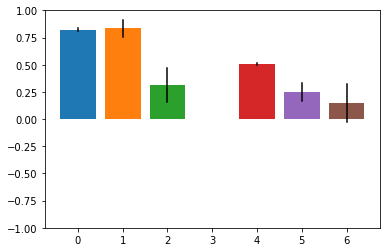

In [40]:
# View / Plot Enrichment within these different categories
data = []
labels = ["Human Interface (Proteome) HGMD Muts", "Human Interface (SARS2 Interactors) HGMD Muts", "Viral Interface HGMD Muts", "Human Interface (Proteome) ClinVar Muts", "Human Interface (SARS2 Interactors) ClinVar Muts", "Viral Interface ClinVar Muts"]
masks = [insider_hgmd_masks_all, insider_hgmd_masks, viral_hgmd_masks, insider_clinvar_masks_all, insider_clinvar_masks, viral_clinvar_masks]
for m_set, l in zip(masks, labels):
    print l
    mask1 = np.concatenate(m_set[0])
    mask2 = np.concatenate(m_set[1])
    data.append(my.odds_ratio(mask1, mask2, verbose=True, log_odds=True, error="SE"))
    print data[-1]
    print
for i in range(len(data)):
    plt.bar(x=i + int(i)/3, height=data[i][0])
    plt.plot([i + int(i)/3, i + int(i)/3], data[i][1:3], color="k")
plt.ylim(-1, 1)

In [84]:
# Hard coded numbers
# From GWAS Dataset enrichment?
a = 3
b = 29
c = 1712
d = 20813
exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1
my.odds_ratio(exposure_mask, case_mask, log_odds=True)

(0.33071182984978609,
 2.0470816900191311,
 -1.3856580303195591,
 0.7056922616438337)

In [86]:
# Human Interactors with Enrichment of Disease Mutations
# by HGMD in their human-viral Interfaces
summary[summary["p_V:H"] <= 0.05].sort_values("OR_V:H")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar    OR_V:H  \
8217  P16435          20.0         207.0    45.0       23.0  2.362236   
5106  Q86UT6          36.0         145.0     3.0        8.0  3.742622   
3584  Q96IV0           9.0         148.0     6.0        3.0  4.000000   

        Up_V:H   Low_V:H     p_V:H    OR_V:C    Up_V:C   Low_V:C     p_V:C  \
8217  3.893568  0.830904  0.002499  0.603254  3.568440 -2.361933  0.690081   
5106  7.239795  0.245450  0.035947  1.927548  4.989366 -1.134270  0.217246   
3584  7.256765  0.743235  0.016073       NaN       NaN       NaN       NaN   

        OR_H:H    Up_H:H   Low_H:H     p_H:H    OR_H:C    Up_H:C   Low_H:C  \
8217  0.928839  1.812195  0.045483  0.039315 -0.330185  1.033756 -1.694125   
5106  3.535357  7.007935  0.062779  0.046000  0.941667  3.264584 -1.381251   
3584 -0.552934  2.555915 -3.661783  0.727393  0.777608  4.250862 -2.695647   

         p_H:C  
8217  0.635164  
5106  0.426886  
3584  0.660803

In [87]:
# Human Interactors with Enrichment of Disease Mutations
# by ClinVar in their human-viral Interfaces
summary[summary["p_V:C"] <= 0.05].sort_values("OR_V:C")

Empty DataFrame
Columns: [UniProt, n_Ires_Viral, n_Ires_Human, n_HGMD, n_Clinvar, OR_V:H, Up_V:H, Low_V:H, p_V:H, OR_V:C, Up_V:C, Low_V:C, p_V:C, OR_H:H, Up_H:H, Low_H:H, p_H:H, OR_H:C, Up_H:C, Low_H:C, p_H:C]
Index: []

In [88]:
# Human Interactors with Enrichment of Disease Mutations
# by HGMD in their human-human Interfaces
summary[summary["p_H:H"] <= 0.05].sort_values("OR_H:H")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar  OR_V:H  Up_V:H  \
5951   Q13496           0.0         156.0    64.0       57.0     NaN     NaN   
9840   P00797           0.0         251.0     7.0       10.0     NaN     NaN   
9782   P62854           0.0          91.0     6.0        2.0     NaN     NaN   
6092   P36871           0.0         191.0    17.0       20.0     NaN     NaN   
4972   Q9BSQ5           0.0         149.0    16.0        9.0     NaN     NaN   
1439   P61764           0.0         215.0    40.0       44.0     NaN     NaN   
14898  P51688           0.0         140.0    81.0       44.0     NaN     NaN   
6419   P49675           0.0          91.0    26.0        7.0     NaN     NaN   
16143  P55851           0.0         218.0     7.0        3.0     NaN     NaN   
8509   P05062           0.0         121.0    22.0       15.0     NaN     NaN   
10592  Q15466           0.0         147.0    14.0        3.0     NaN     NaN   
14126  Q13148           0.0         114.0    38.0       16.0     NaN     NaN   
10995  P08123           0.0         169.0   253.0       97.0     NaN     NaN   
10661  Q9UM01           0.0         139.0    25.0       33.0     NaN     NaN   
9180   P28329           0.0         195.0    37.0       31.0     NaN     NaN   
13999  P19971           0.0         148.0    47.0       62.0     NaN     NaN   
11566  Q9Y3Z3           0.0         236.0    21.0       18.0     NaN     NaN   
10923  P00441           0.0         101.0    91.0       28.0     NaN     NaN   
1904   Q01968           0.0         210.0    69.0       42.0     NaN     NaN   
5085   P16615           0.0         379.0   104.0       20.0     NaN     NaN   
14635  P05093           0.0         204.0    53.0       20.0     NaN     NaN   
16319  Q9BY41           0.0         138.0    24.0       13.0     NaN     NaN   
5373   P05107           0.0         391.0    41.0       34.0     NaN     NaN   
86     P29400           0.0          86.0   281.0      225.0     NaN     NaN   
8780   Q03426           0.0         111.0    95.0       61.0     NaN     NaN   
1251   P07686           0.0         161.0    37.0       30.0     NaN     NaN   
5504   P82251           0.0         171.0    56.0       18.0     NaN     NaN   
13422  P16278           0.0         179.0   121.0       55.0     NaN     NaN   
10641  P02452           0.0         151.0   282.0      109.0     NaN     NaN   
11799  P10253           0.0         219.0   204.0      149.0     NaN     NaN   
...       ...           ...           ...     ...        ...     ...     ...   
12761  Q8TCU4           0.0          34.0     6.0       33.0     NaN     NaN   
1020   Q9BXL7           0.0          87.0     3.0       30.0     NaN     NaN   
14326  Q9UL01           0.0          35.0     2.0        9.0     NaN     NaN   
14558  P12035           0.0          65.0     4.0        3.0     NaN     NaN   
2931   P48634           0.0          14.0     7.0        0.0     NaN     NaN   
10319  P48645           0.0           7.0     2.0        0.0     NaN     NaN   
4203   Q719H9           0.0          56.0     8.0        7.0     NaN     NaN   
14470  Q14739           0.0          31.0     7.0       22.0     NaN     NaN   
12555  Q7Z3E5           0.0          20.0     5.0        0.0     NaN     NaN   
15167  P41732           0.0           9.0     2.0        1.0     NaN     NaN   
14403  Q05996           0.0          25.0     2.0        0.0     NaN     NaN   
7016   Q15283           0.0          28.0     2.0        3.0     NaN     NaN   
12081  Q15392           0.0           7.0     8.0       13.0     NaN     NaN   
16147  Q9P0N5           0.0           5.0     2.0       10.0     NaN     NaN   
2457   Q969G3           0.0          24.0     3.0       15.0     NaN     NaN   
6098   P31271           0.0          52.0     6.0        2.0     NaN     NaN   
11030  Q8TEA7           0.0          24.0     2.0        2.0     NaN     NaN   
9346   Q03001           0.0         166.0     2.0       32.0     NaN     NaN   
3194  

In [89]:
# Human Interactors with Enrichment of Disease Mutations
# by ClinVar in their human-human Interfaces
summary[summary["p_H:C"] <= 0.05].sort_values("OR_H:C")

UniProt  n_Ires_Viral  n_Ires_Human  n_HGMD  n_Clinvar    OR_V:H  \
1441   P61769           0.0         101.0     2.0        3.0       NaN   
6732   P47897           0.0         311.0     8.0       24.0       NaN   
14635  P05093           0.0         204.0    53.0       20.0       NaN   
3688   P24752           0.0         162.0    40.0       28.0       NaN   
5951   Q13496           0.0         156.0    64.0       57.0       NaN   
4631   P40939           0.0         240.0    24.0       21.0       NaN   
86     P29400           0.0          86.0   281.0      225.0       NaN   
10173  P16930           0.0         119.0    43.0       23.0       NaN   
9404   P61244           0.0          80.0    10.0       17.0       NaN   
1520   Q9UMX1           0.0         162.0     9.0       31.0       NaN   
2477   Q09472           0.0         681.0    15.0       79.0       NaN   
1904   Q01968           0.0         210.0    69.0       42.0       NaN   
10923  P00441           0.0         101.0    91.0       28.0       NaN   
8780   Q03426           0.0         111.0    95.0       61.0       NaN   
12747  P04637           0.0         280.0   152.0      229.0       NaN   
8591   Q08289           0.0         270.0    25.0       59.0       NaN   
15368  P41250           0.0         328.0    28.0       46.0       NaN   
6572   P35557           0.0         126.0   280.0      100.0       NaN   
10013  P15289           0.0         127.0   124.0       97.0       NaN   
13999  P19971           0.0         148.0    47.0       62.0       NaN   
4484   P09493           0.0         179.0    79.0       93.0       NaN   
9461   P13637           0.0         427.0    63.0       60.0       NaN   
14103  P11310          68.0         172.0    99.0       76.0 -0.290834   
1546   P02461           0.0         240.0   251.0      300.0       NaN   
6647   P35555          37.0         414.0   794.0      536.0 -0.253274   
14540  P21359           0.0         217.0   302.0      627.0       NaN   
4970   P11532           0.0         346.0   102.0      371.0       NaN   
7679   P04275           0.0         404.0   419.0      254.0       NaN   
15344  Q8WZ42           0.0        1118.0   203.0     3117.0       NaN   
1300   P35609           0.0         396.0    36.0      136.0       NaN   
...       ...           ...           ...     ...        ...       ...   
10034  Q9NR61           0.0          22.0     8.0        6.0       NaN   
7029   P23508           0.0          17.0     0.0        4.0       NaN   
3810   Q9ULG1           0.0          45.0     6.0        3.0       NaN   
12081  Q15392           0.0           7.0     8.0       13.0       NaN   
7830   Q9H3S5           0.0          12.0     0.0        3.0       NaN   
10467  P05546           0.0          50.0     3.0        3.0       NaN   
6940   O14841           0.0          66.0    20.0        4.0       NaN   
11072  Q8WVX9           0.0          14.0     2.0        3.0       NaN   
12458  Q9H4F8           0.0          23.0     5.0        4.0       NaN   
10459  P05549           0.0          24.0    22.0        8.0       NaN   
8691   Q9BWT7           0.0          34.0     6.0        5.0       NaN   
5696   Q8NFF5           0.0          27.0     2.0        2.0       NaN   
14533  Q8WXG6           0.0          74.0     4.0        2.0       NaN   
10070  Q9H0W5           0.0          13.0     0.0        3.0       NaN   
12917  P35716           0.0          55.0     5.0        4.0       NaN   
2585   Q99592           0.0          23.0     6.0        4.0       NaN   
4203   Q719H9           0.0          56.0     8.0        7.0       NaN   
2445   P56645           0.0          23.0     5.0        3.0       NaN   
6366   Q9UNQ0           0.0          24.0    19.0        2.0       NaN   
12654  Q9UMN6           0.0          86.0    14.0        2.0       NaN   
9962   Q5K651           0.0          46.0    14.0        2.0       NaN   
9949   Q70Z35           0.0          43.0     3.0        2.0       NaN   
11030  Q8T

In [90]:
mask1 = np.concatenate(viral_hgmd_masks[0])
mask2 = np.concatenate(viral_hgmd_masks[1])
my.odds_ratio(mask1, mask2, verbose=True, log_odds=True)

               Case  Non-Case
Exposed        90.0    2765.0
Non-Exposed  1687.0   64371.0


(0.31266833368055424,
 0.62346437109754071,
 0.0018722962635675587,
 0.048635732391637099)

# Analyze Term Enrichment Based on Disease Ontology DAG

In [ ]:
# The goal here is to re-do the enrichment calculations looking at disease terms
# in the context of a full disease ontology. Where for instance, a particular variant
# may only be listed under a specific phenotype "Colorectal Cancer" but could also
# apply to a more general "Cancer" term.
#
# In this way, when we count a term, we also add that count to all its parents so that
# we can accurately look at enrichment at all levels of specificity. This avoids running
# into issues where we have low counts (can't do good statistical analysis) from many specific
# terms, and could instead do a good enrichment test on a more general common parent term.

In [92]:
## Read in Disease Ontology Directed Acyclic Graph
#disease_dag = pd.read_csv("{0}/medgen_dag_from_charles.txt".format(base_dir), sep="\t")
#disease_dag.head()

MedGen  Count                            PreferredName  Layer Layer 13  \
0  C0745103    664          Familial hypercholesterolemia 1      5      NaN   
1  C0950123    583                  Inborn genetic diseases      1      NaN   
2  C0024796    524                          Marfan syndrome      2      NaN   
3  C0027672    512  Hereditary cancer-predisposing syndrome      2      NaN   
4  C4746986    357    Alport syndrome 1, X-linked recessive      3      NaN   

  Layer 12 Layer 11 Layer 10 Layer 9 Layer 8 Layer 7   Layer 6  \
0      NaN      NaN      NaN     NaN     NaN     NaN  C0020473   
1      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
2      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
3      NaN      NaN      NaN     NaN     NaN     NaN       NaN   
4      NaN      NaN      NaN     NaN     NaN     NaN       NaN   

                               Layer 5  \
0  C0020445,C0023772,C0242339,C0745103   
1                                  NaN   
2  C0000772,C0005941,C0152021,C3273258   
3                                  NaN   
4                                  NaN   

                                             Layer 4  \
0                         C0020476,C0025521,C0154251   
1                                                NaN   
2  C0000768,C0005940,C0018798,C0410787,C1334997,C...   
3                                                NaN   
4                                                NaN   

                                             Layer 3  \
0                                           C0025517   
1                                                NaN   
2  C0009782,C0018799,C0026857,C0039978,C0243050,C...   
3                                                NaN   
4                                           C4746986   

                                             Layer 2  \
0                                           C1709248   
1                                                NaN   
2  C0007222,C0024796,C0851355,C1333150,C1709247,C...   
3                                  C0027672,C1882062   
4                                           C1567741   

                               Layer 1   Layer 0  
0                             C1709246  C0012634  
1                    C0019247,C0950123  C0012634  
2  C0039082,C0678236,C1333305,C1709246  C0012634  
3           C0019247,C0027651,C0039082  C0012634  
4                             C0039082  C0012634

In [93]:
# Read in Raw MedGen Relationships
medgen_rel = pd.read_csv("{0}/MGREL.RRF".format(base_dir), sep="|")
medgen_rel.head()

#CUI1      AUI1 STYPE1  REL      CUI2       AUI2              RELA  \
0  C0000039  A0016515    AUI   SY  C0000039  A12080359   sort_version_of   
1  C0000039  A0016515    AUI   SY  C0000039  A12091182  entry_version_of   
2  C0000039  A0016515    AUI   SY  C0000039   A1317708  permuted_term_of   
3  C0000039  A0016515   SDUI  SIB  C0012456   A0049151               NaN   
4  C0000039  A0016515   SDUI  SIB  C0031617  A12995624               NaN   

         RUI  SAB   SL SUPPRESS  Unnamed: 11  
0  R64565540  MSH  MSH        N          NaN  
1  R64592881  MSH  MSH        N          NaN  
2  R28482432  MSH  MSH        N          NaN  
3  R71241360  MSH  MSH        N          NaN  
4  R71104054  MSH  MSH        N          NaN

In [95]:
# Total Number of Terms
all_terms = set(medgen_rel["#CUI1"].to_list() + medgen_rel["CUI2"].to_list())
print len(all_terms)

# Only Terms involved in Parent / Child Relationships
child_parent_terms = set(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["#CUI1"].to_list() + medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["CUI2"].to_list())
print len(child_parent_terms)

194879
71376


In [100]:
# NOTE: Only the ClinVar dataset lists MedGen terms, so we
#       only work with this dataset here

# Subset of MedGen Terms from ClinVar
clinvar_terms = set(my.flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
print len(clinvar_terms)

# Overlap with Parent / Child Terms
print len(clinvar_terms.intersection(child_parent_terms))

# Overlap with All Terms from MedGen Relationships
# I'm unsure what's up with the ~1500 that are missing
# from the MedGen REL file (maybe they just aren't in any
# relationships?)
print len(clinvar_terms.intersection(all_terms))

6275
2628
4777


In [102]:
import networkx as nx

In [104]:
# Here we being constructing a directed graph for the disease ontology
# We first add in all the parent child relationships listed in the MedGene
# relationships.
#
dag = nx.DiGraph()

# Add all the Nodes.
# Each node stores the counts that will be used for its enrichment
# We start these as out with no disease gene counts (e.g. everything
# is either an interacotr non-disease gene (b) or a non-interactor
# non-disease gene (d)). As we parse the graph we will update these
# counts by adding / subtracting as necessary and propogating the
# changed through to the parent nodes
for c1, c2 in tqdm_notebook(medgen_rel[["#CUI1", "CUI2"]].values):
    dag.add_node(c1, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})
    dag.add_node(c2, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})

# Add all the relationships
for c1, c2, rel in tqdm_notebook(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])][["#CUI1", "CUI2", "REL"]].values):
    if(rel == "PAR"):
        dag.add_edge(c2, c1)
    else:
        dag.add_edge(c1, c2)

# Add in any extra terms from ClinVar Table with no relationships
for c in set(my.flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list())):
    dag.add_node(c, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})

In [105]:
# Updates the counts for a node and its predecessors
def propogate_updates(g, n, is_interactor):
    # If the node doesn't exist, initialize it
    if(not n in g.nodes):
        g.add_node(n, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})
    #print n
    
    # If the node has been blocked (i.e. has already been visited
    # in this round of updates, then stop)
    if(g.node[n]["block"]):
        #print "Already Reached", n
        return
    
    # Otherwise, update the count as necessary depending on if this gene
    # is / is not an interactor of SARS2
    else:
        if(is_interactor):
            g.node[n]["a"] += 1
            g.node[n]["b"] -= 1
        else:
            g.node[n]["c"] += 1
            g.node[n]["d"] -= 1
        
        # Block this node so that it is not revisited
        g.node[n]["block"] = True
        
        # Propogate the update through all parent terms
        for p in g.predecessors(n):
            propogate_updates(g, p, is_interactor)
# FUNCTION END

# Unblocks all the nodes in the network
def unblock_all(g):
    for n in g.nodes:
        g.node[n]["block"] = False
# FUNCTION END

# Resets all the nodes in the network to their initial conditions
def reset_all(g):
    for n in g.nodes:
        for k, v in {"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False}.iteritems():
            g.node[n][k] = v
# FUNCTION END

In [106]:
# Make sure the network is reinitialized with starting counts
reset_all(dag)

In [107]:
# Iterate through all Uniprot IDs in the ClinVar Data
for uni, g in tqdm_notebook(clinvar[["UNIPROT_ACC", "PHEN_IDS", "PHEN"]].groupby("UNIPROT_ACC")):
    # Fetch all the MedGen terms associated with this gene
    med_gen_terms = set(my.flatten(g["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
    
    # Figure out if this is an interactor
    is_interactor = uni in uni2seq.keys()
    
    # Udate the gene counts for all terms
    # this gene is invovled in and its parents
    for n in med_gen_terms:
        propogate_updates(dag, n, is_interactor)
    
    # Unblock all nodes in the network to prepare for adding the next gene
    unblock_all(dag)

In [110]:
# Store initial summary reporting each term, the counts, and its
# list of immediate children and parents.
summary = []
for n in tqdm_notebook(dag.nodes):
    summary.append([n, dag.nodes[n]["a"], dag.nodes[n]["b"], dag.nodes[n]["c"], dag.nodes[n]["d"], ",".join(dag.successors(n)), ",".join(dag.predecessors(n))])
summary = pd.DataFrame(summary, columns=["ID", "A", "B", "C", "D", "Children", "Parents"])

# Save this summary
summary.to_csv("{0}/MedGen_Term_Enrichments.txt".format(base_dir), sep="\t", index=None)

In [111]:
# Only retain information for the terms that have at least
# one gene associated with them
summary = summary[(summary["A"] != 0)|(summary["C"] != 0)]

# Calculate Odds Ratio for enrichment of SARS2 interactors
# within each disease term
def do(a, b, c, d):
    if([0] in [a, b, c, d]):
        return np.nan, np.nan, np.nan, np.nan
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[a+b:a+b+c] = 1

    OR, up, low, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True, two_sided=False)
    pbar.update()
    return OR, low, up, p
# FUNCTION END

# Calculate OR / Format the results into new columns
pbar = tqdm_notebook(total=len(summary))
tmp = summary[["A", "B", "C", "D"]].apply(lambda x: do(*x), axis=1)
summary["LogOR"] = [x[0] for x in tmp]
summary["Low"] = [x[1] for x in tmp]
summary["Up"] = [x[2] for x in tmp]
summary["p-value"] = [x[3] for x in tmp]

In [112]:
# Number of significnatly enriched terms
print len(summary[summary["p-value"] <= 0.05])

349


In [113]:
# Read in MedGene Term Descriptions to get named for each term
medgen_names = pd.read_csv("{0}/MGCONSO.RRF".format(base_dir), sep="|")
medgen_names.head()

#CUI TS STT ISPREF        AUI  SAUI      SCUI     SDUI  SAB  TTY  \
0  C0000005  P  PF      Y  A26634265   NaN  M0019694  D012711  MSH  PEP   
1  C0000005  S  PF      Y  A26634266   NaN  M0019694  D012711  MSH   ET   
2  C0000039  P  VC      Y   A0016515   NaN  M0023172  D015060  MSH   MH   
3  C0000039  S  VW      Y   A0100864   NaN  M0023172  D015060  MSH   PM   
4  C0000039  S  PF      Y   A0528280   NaN  M0023172  D015060  MSH   N1   

      CODE                                                STR SUPPRESS  \
0  D012711                     (131)I-Macroaggregated Albumin        N   
1  D012711                                         (131)I-MAA        N   
2  D015060                 1,2-Dipalmitoylphosphatidylcholine        N   
3  D015060                   Phosphatidylcholine, Dipalmitoyl        N   
4  D015060  3,5,9-Trioxa-4-phosphapentacosan-1-aminium, 4-...        N   

   Unnamed: 13  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [114]:
# Create term --> name mapping
term2name = defaultdict(str)
term2name.update(medgen_names[(medgen_names["TS"] == "P")&(medgen_names["STT"] == "PF")].drop_duplicates("#CUI")[["#CUI", "STR"]].set_index("#CUI")["STR"].to_dict())

In [115]:
# Update Summary with correct Name
summary["Name"] = summary["ID"].map(lambda x: term2name[x])

In [116]:
# Add Enrichment information / name back into the network
for id, a, b, c, d, OR, low, up, p, name in summary[["ID", "A", "B", "C", "D", "LogOR", "Low", "Up", "p-value", "Name"]].values:
    dag.node[id]["OR"] = OR
    dag.node[id]["low"] = low
    dag.node[id]["up"] = up
    dag.node[id]["p"] = p
    dag.node[id]["name"] = name

In [117]:
# Function to add a node and its ancestors from the original dag to a new graph g
def add_node_plus_acnestors(g, n, nodes=set(), edges=set()):
    # If the node is already in the set of nodes stop
    if(n in nodes):
        return
    
    # Add the node to the graph and add it to the list of nodes
    g.add_node(n, **dag.node[n])
    nodes.add(n)
    
    # If there are no ancestor nodes for this node,
    # add connect it to a universal root node
    if(len(list(dag.predecessors(n))) == 0):
        g.add_edge("root", n)
        edges.add(("root", n))
    
    # Otherwise add all the ancestors
    for p in dag.predecessors(n):
        if(not (p, n) in edges):
            g.add_edge(p, n)
            edges.add((p, n))
        
        add_node_plus_acnestors(g, p, nodes, edges)
    
    return
# FUNCTION END

In [118]:
# Create a sub-set for the term network containing only significant terms and their
# ancestors
sub_dag = nx.DiGraph()
sub_dag.add_node("root", **{"name":"root"})
nodes = set("root")
edges = set()
for n in tqdm_notebook(summary[summary["p-value"] <= 0.05].sort_values("A", ascending=False)["ID"]):
    add_node_plus_acnestors(sub_dag, n, nodes, edges)

In [119]:
len(sub_dag.nodes)

601

In [120]:
len(edges)

1021

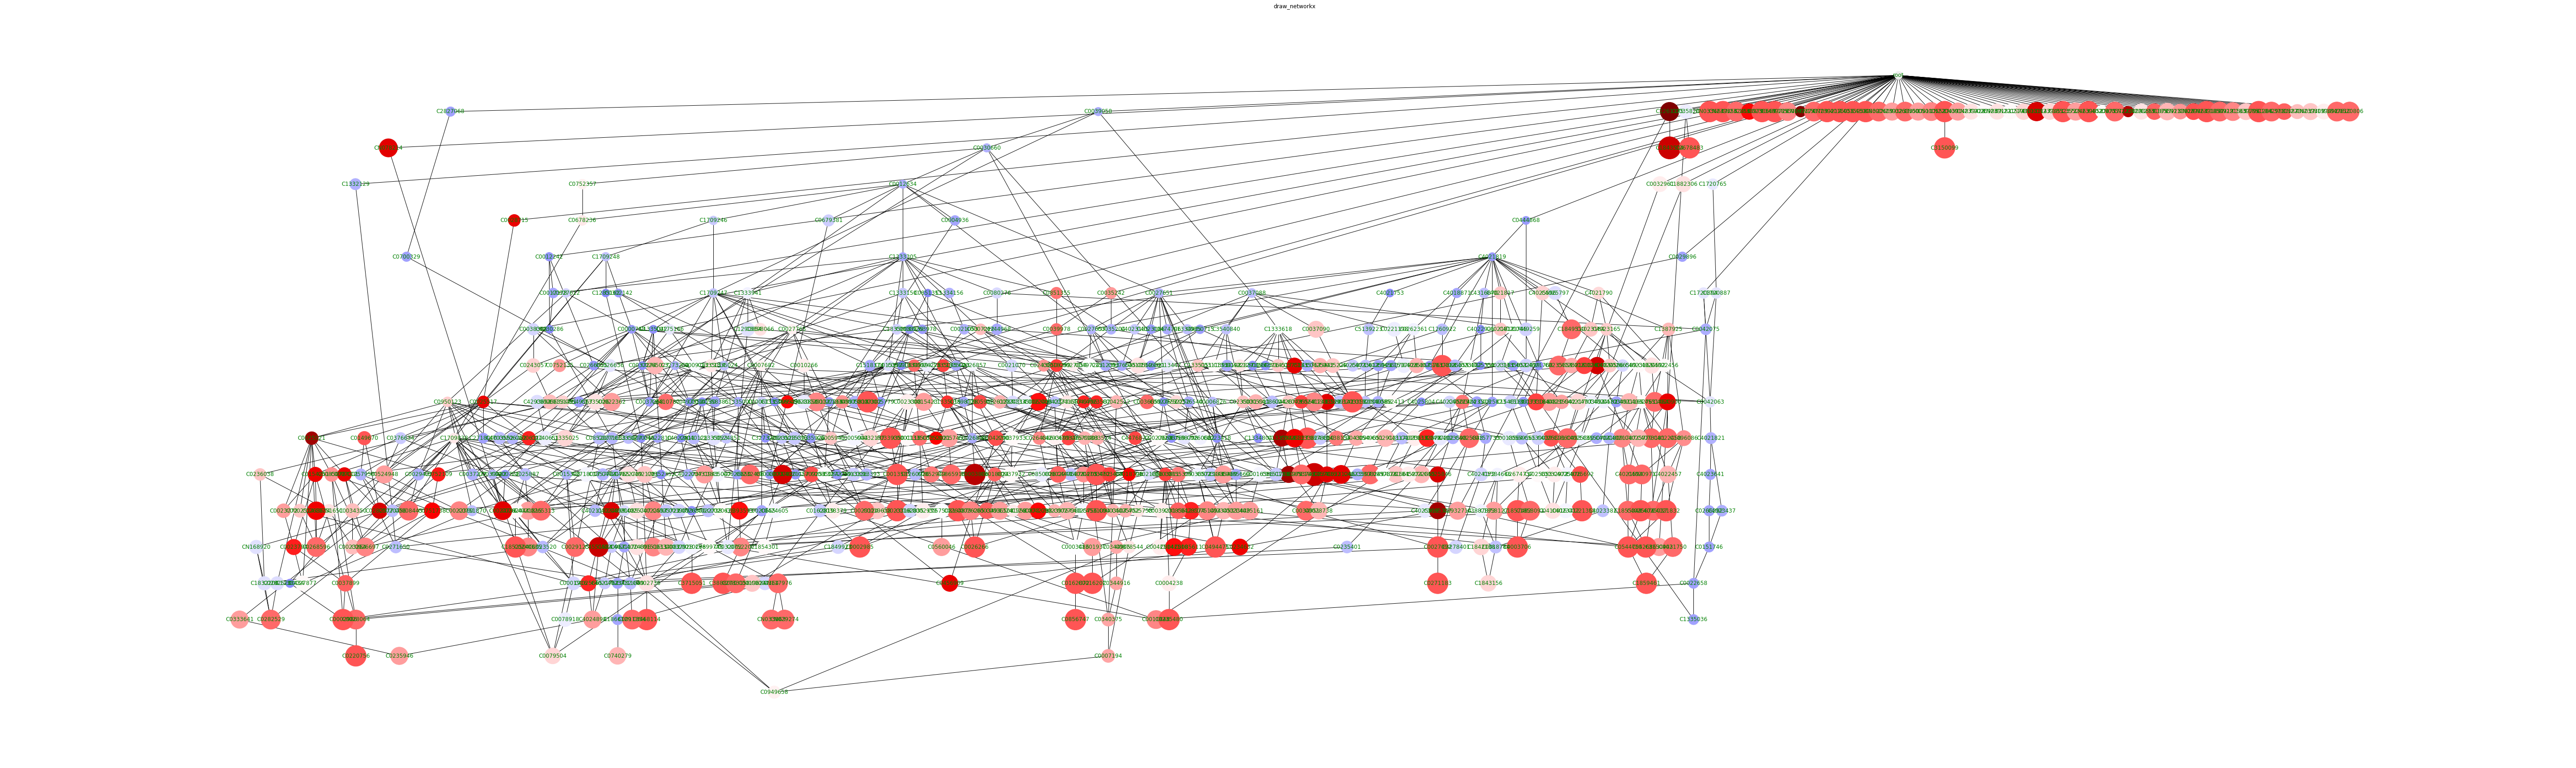

In [121]:
# Attempt to plot the sub-network of significant genes
#
# Can't be meaningfully viewed from here, but the svg can be saved
# and inspected

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
#write_dot(sub_dag,'{0}/test.dot'.format(base_dir))

# same layout using matplotlib with no labels
#plt.figure(figsize=(200*3, 60*3))
plt.figure(figsize=(100, 30))
plt.title('draw_networkx')
pos = graphviz_layout(sub_dag, prog='dot')


# Add color based on level of significance
vmax = 10
cmap = lambda x: matplotlib.cm.seismic(1 - (float((np.log(x) - np.log(0.05) + vmax)) / (vmax*2.0)))
colors = []

# Add size based on Odds Ratio
sizes = []

# Add label from term name
labels = dict()
for n in sub_dag.nodes:
    if("p" in sub_dag.node[n]):
        colors.append(cmap(sub_dag.node[n]["p"]))
        sizes.append(300 + 300*abs(sub_dag.node[n]["OR"]))
        labels[n] = "{0} ({1})\nOR: {2:0.2f} ({3:0.2f}={4:0.2f})\np: {5}\n{6}\t{7}\n{8}\t{9}".format(n, sub_dag.node[n]["name"], sub_dag.node[n]["OR"], sub_dag.node[n]["low"], sub_dag.node[n]["up"], sub_dag.node[n]["p"], sub_dag.node[n]["a"], sub_dag.node[n]["b"], sub_dag.node[n]["c"], sub_dag.node[n]["d"])
    else:
        colors.append("#EEEEEE")
        sizes.append(300)
        labels[n] = n

nx.draw(sub_dag, pos, labels=None, arrows=False, node_color=colors, node_size=sizes, font_color="g")
#plt.savefig('nx_test.svg')
#plt.savefig('nx_test.png')

In [122]:
# Add list of significant parent / child terms to the summary
# This way we can select to view the results based on only the most
# specific or most general term (while retaining significance)
summary["Significant Parents"] = summary["Parents"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))
summary["Significant Children"] = summary["Children"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))

In [123]:
# Add lists of all Significant Ancestors / Descendents relative to
# the given node
def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.predecessors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Ancestors"] = tmp

def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.successors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Descendants"] = tmp

8532/|/100%|| 8532/8532 [01:50<00:00, 96.94it/s]
8532/|/100%|| 8532/8532 [00:21<00:00, 2308.32it/s]

In [125]:
# Save the updated Term Enrichments Summary
summary.to_csv("{0}/MedGen_Term_Enrichments.txt".format(base_dir), sep="\t", index=None)

In [126]:
# All significant nodes with at least 2 SARS2 interactors in the disease terms.
# Also filtered so that we only so the most general term possible what is still significant
# i.e. from any significant node, we continue to go up the network until significance is lost
# at the next parent
summary[(summary["p-value"] <= 0.05)&(summary["Significant Ancestors"] == "")&(summary["A"] > 1)].sort_values("LogOR", ascending=False)[["Name", "ID", "A", "B", "C", "D", "LogOR", "p-value"]]

Name        ID   A    B  \
36366                                                      CN001147   2  330   
11817                       Pontoneocerebellar hypoplasia  C1261175   3  329   
95738                                 Familial aortopathy  CN078214   2  330   
176066                                                     CN029864   2  330   
122498                             Hirschsprung disease 1  C2931876   2  330   
28121            Primary autosomal recessive microcephaly  C3711387   2  330   
30361               Hereditary connective tissue disorder  C0410787   2  330   
110586  Mitochondrial complex I deficiency, nuclear ty...  C1838979   3  329   
33769                     Finding of head and neck region  C0575141   4  328   
56670                                                      CN118826   2  330   
171131                         Abnormality of body weight  C4025357   2  330   
19022                          Respiratory System Finding  C0425442   2  330   
43484       Combined oxidative phosphorylation deficiency  CN228601   2  330   
195301                Stomatognathic System Abnormalities  C0243057   2  330   
15087                    Abnormality of connective tissue  C4025596   2  330   
126083                            Abnormal eye physiology  C4022924   4  328   
29657                                        Bone disease  C0005940   6  326   
116327                               Abnormal muscle tone  C0852413   2  330   
71934                              Cardiovascular finding  C0425560   7  325   
48466                        Non-Neoplastic Bone Disorder  C1334997   5  327   
160295                               Abnormality of limbs  C1387925   4  328   
163960              Non-Neoplastic Head and Neck Disorder  C1335014   3  329   
181820                        Abnormality of head or neck  C4021817   4  328   
14440                  Connective and Soft Tissue Finding  C3714517   4  328   
18957                                Congenital anomalies  C0151491   4  328   
183922                Pathological Conditions, Anatomical  C0752135   6  326   
187296                                                     C4020875   3  329   
24282                                                      C0311392   3  329   
14392                            Otolaryngologic Disorder  C3898066   4  328   
164205                 Abnormality of the skeletal system  C4021790   5  327   
40087                                       Other Finding  C1335151   6  326   
132346               Hereditary hearing loss and deafness  C0236038   6  326   
46118                    Nutritional or metabolic disease  C0028715  18  314   
117479                          Neurological observations  C0422837   5  327   
67611                                                      C0851355  12  320   
52154                          Respiratory Tract Diseases  C0035242  12  320   
84615                   Disorder of cardiovascular system  C0007222  11  321   
3947                                        not specified  CN169374  75  257   
193034                                                     CN221809  60  272   
61883                             Inborn genetic diseases  C0950123  27  305   
192290                            Nervous system disorder  C0027765  21  311   
99944                                  Disease Attributes  C0752357  22  310   

           C      D     LogOR   p-value  
36366      5  20013  4.600400  0.000071  
11817      8  20010  4.511452  0.000002  
95738      6  20012  4.337293  0.000120  
176066    13  20005  3.221311  0.001685  
122498    14  20004  3.114324  0.002200  
28121     14  20004  3.114324  0.002200  
30361     15  20003  3.014716  0.002817  
110586    23  19995  2.986808  0.000391  
33769     35  19983  2.799651  0.000128  
56670     19  19999  2.673391  0.006463  
171131    22  19996  2.461670  0.010616  
19022     22  19996  2.461670  0.010616  
43484     24  19994  2.335995  0.014124  
195301    27  19991  2.1

             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  23.0   19995.0
             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  30.0   19988.0
              Case  Non-Case
Exposed        6.0     326.0
Non-Exposed  104.0   19914.0
             Case  Non-Case
Exposed       3.0     329.0
Non-Exposed  56.0   19962.0
             Case  Non-Case
Exposed       4.0     328.0
Non-Exposed  85.0   19933.0
              Case  Non-Case
Exposed       11.0     321.0
Non-Exposed  258.0   19760.0
              Case  Non-Case
Exposed       18.0     314.0
Non-Exposed  458.0   19560.0
              Case  Non-Case
Exposed       12.0     320.0
Non-Exposed  352.0   19666.0


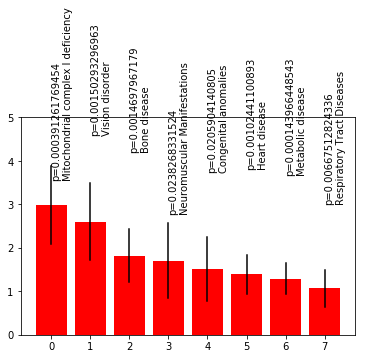

ID   A    B    C      D  \
110586  C1838979   3  329   23  19995   
9867    C0042790   3  329   30  19988   
29657   C0005940   6  326  104  19914   
26180   C0752252   3  329   56  19962   
18957   C0151491   4  328   85  19933   
99426   C0018799  11  321  258  19760   
117422  C0025517  18  314  458  19560   
52154   C0035242  12  320  352  19666   

                                                 Children  \
110586                                                      
9867    C0028077,C0854348,C2717757,C0456909,C0085636,C...   
29657   C0576093,C0029412,C0029411,C0005967,C0014461,C...   
26180   C0039621,C0027125,C0026827,C0026826,C0026821,C...   
18957   C0039093,C0340231,C0264303,C1861922,C0206762,C...   
99426   C1335015,C0032805,C0878544,C0035439,C0007177,C...   
117422  C3714509,C0018099,C0032708,C0235950,C0023787,C...   
52154   C0039978,C0018200,C0035244,C0035243,C0035238,C...   

                           Parents     LogOR       Low        Up   p-value  \
110586                              2.986808  1.524170  4.449447  0.000391   
9867    C0015397,C1333305,C0036659  2.602975  1.159997  4.045952  0.001503   
29657                     C0026857  1.817290  0.812182  2.822398  0.001470   
26180                     C0027854  1.700632  0.288176  3.113089  0.023827   
18957   C0026857,C3273258,C0000768  1.515928  0.294655  2.737202  0.020590   
99426            C0039978,C0007222  1.392070  0.649383  2.134758  0.001024   
117422           C0028715,C1709248  1.291719  0.705747  1.877691  0.000144   
52154                               1.067019  0.357687  1.776350  0.006675   

                                                     Name Significant Parents  \
110586  Mitochondrial complex I deficiency, nuclear ty...                       
9867                                      Vision disorder            C0036659   
29657                                        Bone disease                       
26180                        Neuromuscular Manifestations            C0027854   
18957                                Congenital anomalies                       
99426                                       Heart disease   C0039978,C0007222   
117422                                  Metabolic disease            C0028715   
52154                          Respiratory Tract Diseases                       

                                     Significant Children  \
110586                                                      
9867                           C0456909,C1709253,C0042798   
29657                          C0037933,C0005941,C0544755   
26180                                            C0026827   
18957                                            C0003886   
99426   C1335015,C0878544,C0018824,C0018798,C0042512,C...   
117422  C0006112,C0025521,C0001118,C0751651,C0149670,C...   
52154                                            C0039978   

                      Significant Ancestors  \
110586                                        
9867             C0036659,C0027854,C0027765   
29657                                         
26180                     C0027854,C0027765   
18957                                         
99426   C0039978,C0007222,C0035242,C0851355   
117422                             C0028715   
52154                                         

                                  Significant Descendants  
110586                                                     
9867         C0456909,C0042798,C1709253,C0038379,C0234632  
29657   C3715051,C1859461,C0544755,C0008445,C0265313,C...  
26180                 C0026827,C1853743,C1858127,C1860834  
18957   C1301937,C0022360,C0016508,C0003706,C0524948,C...  
99426   C1335015,C0878544,C0003811,C1260873,C0085612,C...  
117422  C0011854,C0028064,C0006112,C0027877,C0002514,C...  
52154   C1335015,C0878544,C0003811,C1260873,C0085612,C...

In [127]:
# Manual Curation of Disease Terms to highlight in figure
keep = ["Metabolic disease",
"Respiratory Tract Diseases",
"Heart disease",
"Bone disease",
"Vision disorder",
"Mitochondrial complex I deficiency, nuclear type 1",
"Congenital anomalies",
"Neuromuscular Manifestations"]

i = 0
for name, a, b, c, d in summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)[["Name", "A", "B", "C", "D"]].values:
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[a+b:a+b+c] = 1
    
    OR, low, up, p = my.odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False, error="SE")
    
    plt.bar(i, height=OR, color="r")
    plt.plot([i, i], [low, up], color="k")
    plt.text(i, up + 5, "p={0}\n{1}".format(p, name.split(",")[0]), rotation=90)
    i += 1
plt.ylim(0, 5)
#plt.savefig("Figures/Figure_3/Disease_Term_Enrichment.svg")
plt.show()
summary[summary["Name"].isin(keep)].sort_values("LogOR", ascending=False)